# Modeling

In this notebook we
1. Load '../Data/data_eda.csv' which is the output of exploratory data analysis.
2. Apply different model to predict Airbnb listing price.

### Import Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 150)
sns.set_palette(palette)

### Load Data

In [2]:
df = pd.read_csv('../Data/data_eda.csv')
df.head()

,price,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,cancellation_policy,cleaning_fee,latitude_longitude_bin,neighbourhood_cleansed_reverted,shapes,accommodates_bedroom_ratio,accommodates_bathroom_ratio
0,85.0,81,14,0,0,4,1.0,1.0,1.0,4,2,1,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000
1,150.0,81,14,0,0,4,1.0,1.0,1.0,4,1,2,40.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000
2,975.0,81,14,9,0,11,4.5,5.0,7.0,4,10,2,300.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.2,2.444444
3,100.0,81,14,0,0,3,1.0,0.0,2.0,4,1,0,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",6.0,3.000000
4,450.0,81,14,9,0,6,2.0,3.0,3.0,4,6,2,125.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.0,3.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 18 columns):
price                              3818 non-null float64
neighbourhood_cleansed             3818 non-null int64
zipcode                            3818 non-null int64
property_type                      3818 non-null int64
room_type                          3818 non-null int64
accommodates                       3818 non-null int64
bathrooms                          3818 non-null float64
bedrooms                           3818 non-null float64
beds                               3818 non-null float64
bed_type                           3818 non-null int64
guests_included                    3818 non-null int64
cancellation_policy                3818 non-null int64
cleaning_fee                       3818 non-null float64
latitude_longitude_bin             3818 non-null int64
neighbourhood_cleansed_reverted    3818 non-null object
shapes                             3818 non-null object
a

### Prepare functions for Plotting

In [4]:
def get_sub_plot(width = 20, height = 10, label_font_size = 14, tick_font_size = 13):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    ax.tick_params(labelsize = tick_font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)
    return ax

In [5]:
def scatter_plot(price, pred_price):
    ax = get_sub_plot()
    sns.regplot(price, pred_price, fit_reg = False, ax = ax)
    plt.xlabel("Airbnb Listing Price")
    plt.ylabel("Predicted Airbnb Listing Price")
    plt.title("Relationship between Price and Predicted Price")

In [6]:
def dist_plot(price):
    ax = get_sub_plot()
    sns.distplot(price, ax = ax)
    plt.xlabel('Price')
    plt.ylabel('Distribution')
    plt.show()
    
    print ("Skew is:", price.skew())

### Prepare functions for Train Test Split

In [7]:
from sklearn.model_selection import train_test_split

def my_train_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
    return (X_train, X_test, y_train, y_test)

### Prepare function for Scoring & Reporting

In [8]:
from sklearn.metrics import mean_squared_error

def report(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    print ('MSE is: ', mse)
    print ('RMSE is: ', rmse)
    
def summary(y_test, y_pred):
    report(y_test, y_pred)
    scatter_plot(y_test, y_pred)

### Explore Data & Engineer Features

In [9]:
df_property_type_onehot = pd.get_dummies(df['property_type'], prefix = 'property_type')
df_property_type_onehot.head()

,property_type_0,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [10]:
df_neighbourhood_cleansed_onehot = pd.get_dummies(df['neighbourhood_cleansed'], prefix = 'neighbourhood_cleansed')
df_neighbourhood_cleansed_onehot.head()

,neighbourhood_cleansed_0,neighbourhood_cleansed_1,neighbourhood_cleansed_2,neighbourhood_cleansed_3,neighbourhood_cleansed_4,neighbourhood_cleansed_5,neighbourhood_cleansed_6,neighbourhood_cleansed_7,neighbourhood_cleansed_8,neighbourhood_cleansed_9,...,neighbourhood_cleansed_77,neighbourhood_cleansed_78,neighbourhood_cleansed_79,neighbourhood_cleansed_80,neighbourhood_cleansed_81,neighbourhood_cleansed_82,neighbourhood_cleansed_83,neighbourhood_cleansed_84,neighbourhood_cleansed_85,neighbourhood_cleansed_86
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Import packages

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Model 1: K-Nearest Neighbors

In [12]:
# df_X = pd.concat([df[['accommodates', 'bathrooms', 'bedrooms']], df_property_type_onehot, df_neighbourhood_cleansed_onehot], axis = 1)
df_X = pd.concat([df[['accommodates', 'bathrooms', 'bedrooms']], df_property_type_onehot], axis = 1)
X = df_X.as_matrix()
y = df['price'].as_matrix()

In [13]:
from sklearn.neighbors import KNeighborsRegressor

steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsRegressor())]

pipeline = Pipeline(steps)
          
param_grid = {'knn__n_neighbors': np.arange(1, 50)}          

X_train, X_test, y_train, y_test = my_train_test_split(X, y)          
          
cv = GridSearchCV(pipeline, param_grid, cv = 5)
cv.fit(X_train, y_train)
          
print(cv.best_params_)
print(cv.best_score_)

y_pred = cv.predict(X_test)

{'knn__n_neighbors': 11}
0.499937643848


MSE is:  4187.71814902
RMSE is:  64.7125810722


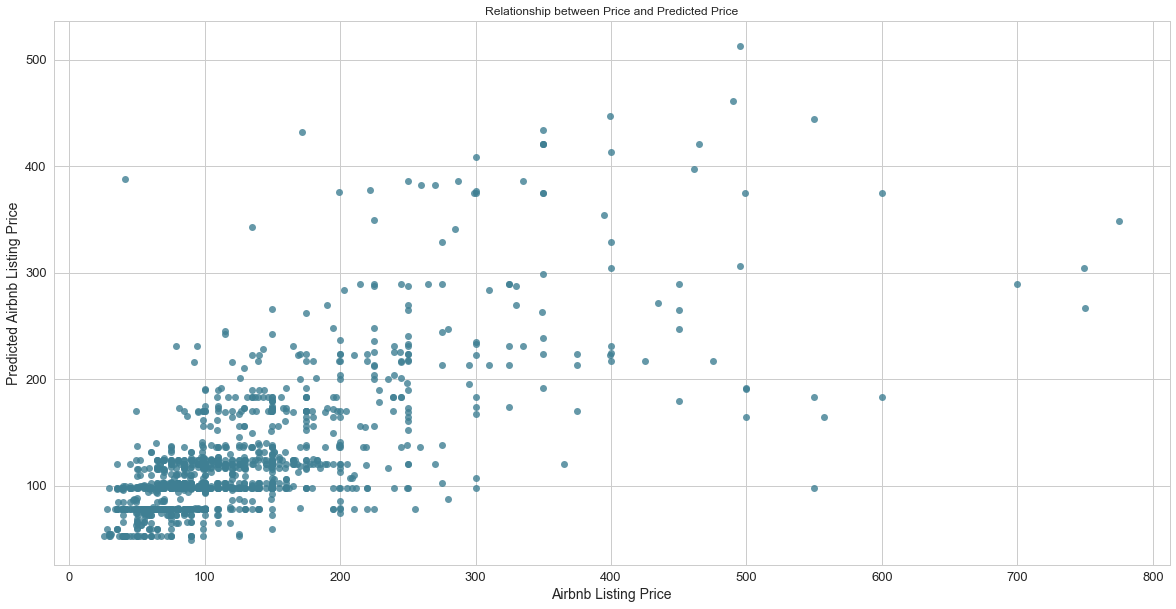

In [14]:
summary(y_test, y_pred)

### Model 2: Linear Regression

In [15]:
# df_X = pd.concat([df[['accommodates', 'bathrooms', 'bedrooms']], df_property_type_onehot, df_neighbourhood_cleansed_onehot], axis = 1)
df_X = pd.concat([df[['accommodates', 'bathrooms', 'bedrooms']], df_property_type_onehot], axis = 1)

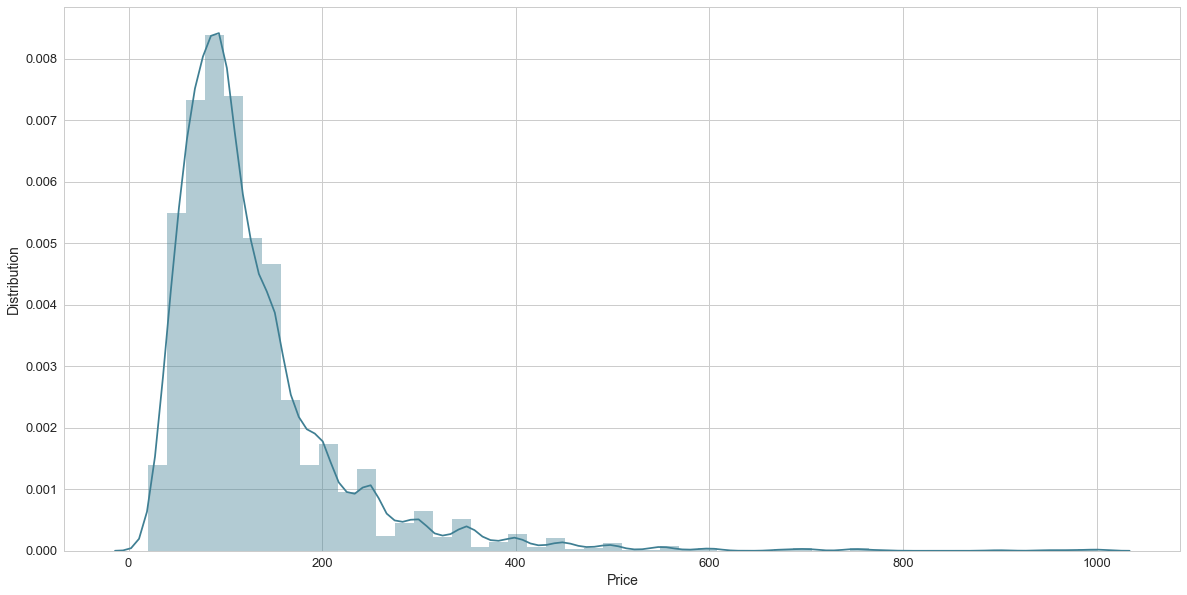

Skew is: 3.11312267004


In [16]:
dist_plot(df.price)

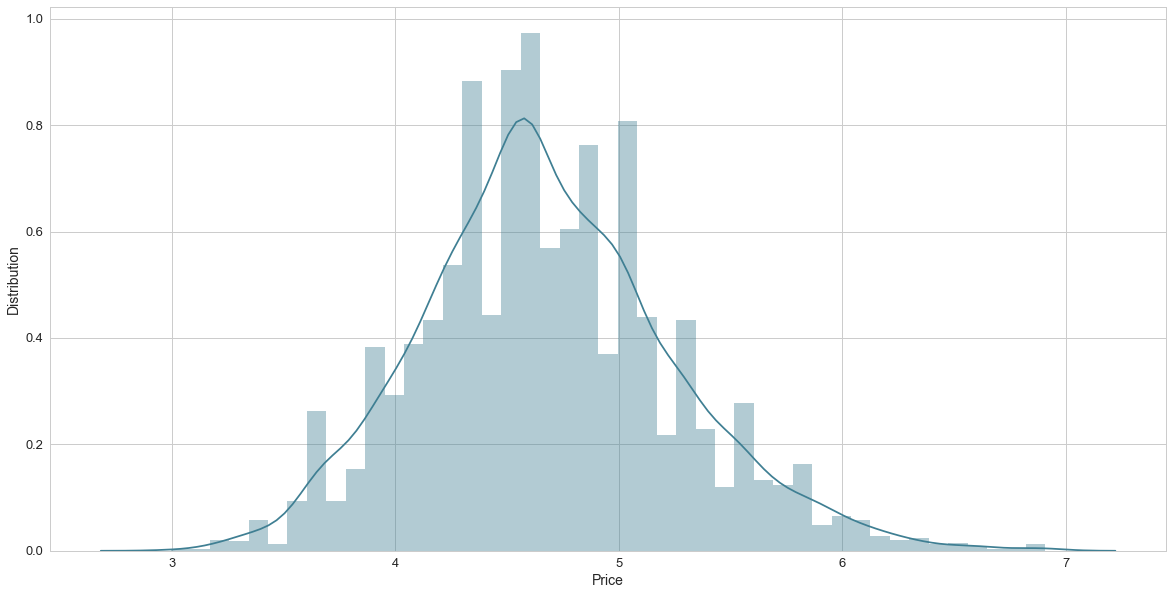

Skew is: 0.372413830121


In [17]:
# Check if taking log and make the price distributed more normally
df['price_log'] = np.log(df.price)

dist_plot(df.price_log)

Yes taking log can make the price distribute more nromally. Let's use the log price to be our target.

In [18]:
X = df_X.as_matrix()
y = df['price_log'].as_matrix()

In [19]:
from sklearn.linear_model import LinearRegression

steps = [('scaler', StandardScaler()),
         ('lm', LinearRegression())]

pipeline = Pipeline(steps)
          
param_grid = {}          

X_train, X_test, y_train, y_test = my_train_test_split(X, y)          
          
cv = GridSearchCV(pipeline, param_grid, cv = 5)
cv.fit(X_train, y_train)
          
print(cv.best_params_)
print(cv.best_score_)

y_pred = cv.predict(X_test)

{}
-1.27024033082e+24


MSE is:  6017.87035212
RMSE is:  77.5749337874


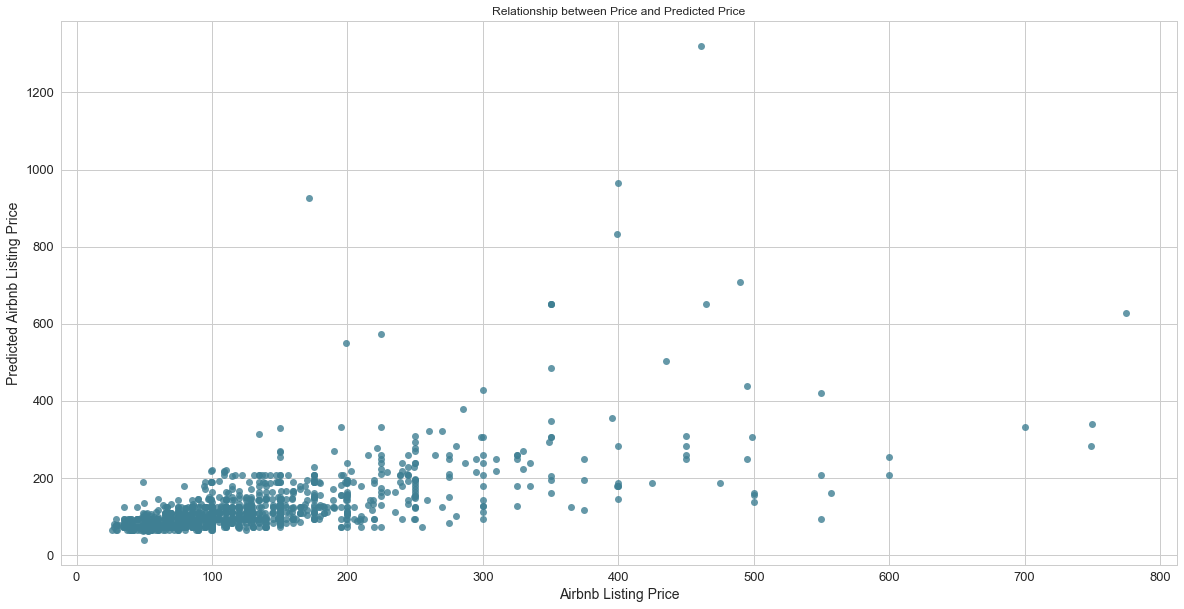

In [20]:
summary(np.exp(y_test), np.exp(y_pred))

### Model 2: Ridge Regularization Model

In [21]:
X = df_X.as_matrix()
y = df['price_log'].as_matrix()

In [22]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 0.1, normalize = True)
X_train, X_test, y_train, y_test = my_train_test_split(X, y)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

In [23]:
from sklearn.linear_model import Ridge

steps = [('scaler', StandardScaler()),
         ('ridge', Ridge())]

pipeline = Pipeline(steps)
          
param_grid = {'ridge__alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}          

X_train, X_test, y_train, y_test = my_train_test_split(X, y)          
          
cv = GridSearchCV(pipeline, param_grid, cv = 5)
cv.fit(X_train, y_train)
          
print(cv.best_params_)
print(cv.best_score_)

y_pred = cv.predict(X_test)

{'ridge__alpha': 50}
0.488509890726


MSE is:  5831.6618992
RMSE is:  76.3653186937


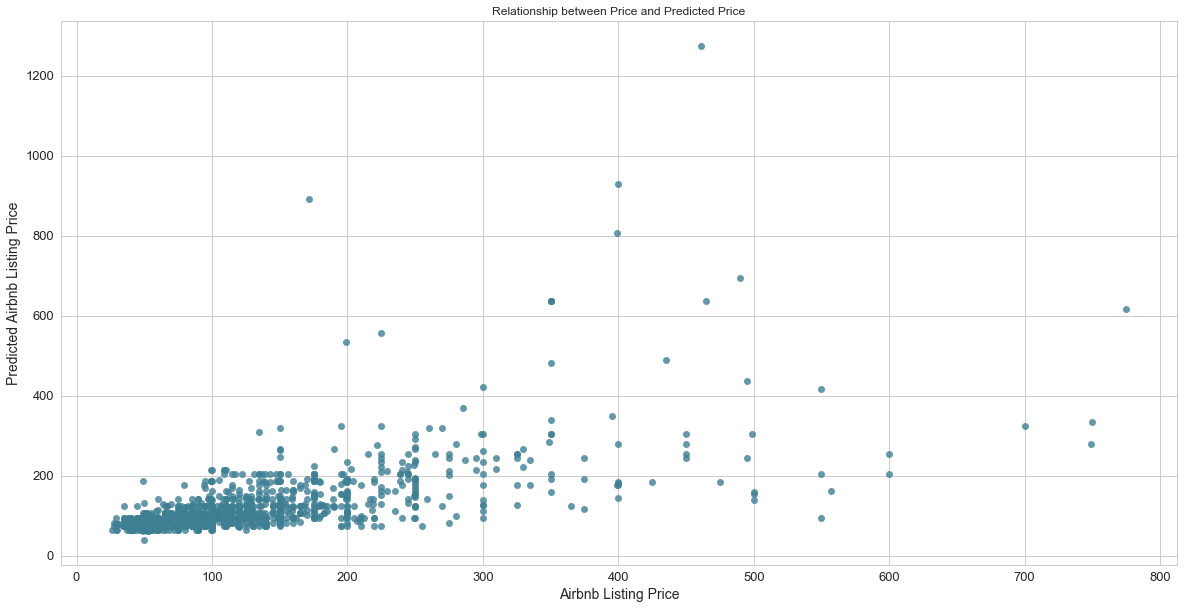

In [24]:
summary(np.exp(y_test), np.exp(y_pred))

### Model 3: Lasso Regularization Model

In [25]:
X = df_X.as_matrix()
y = df['price_log'].as_matrix()

In [26]:
from sklearn.linear_model import Lasso

steps = [('scaler', StandardScaler()),
         ('lasso', Lasso(max_iter = 10000))]

pipeline = Pipeline(steps)
          
param_grid = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}          

X_train, X_test, y_train, y_test = my_train_test_split(X, y)          
          
cv = GridSearchCV(pipeline, param_grid, cv = 5)
cv.fit(X_train, y_train)
          
print(cv.best_params_)
print(cv.best_score_)

y_pred = cv.predict(X_test)

{'lasso__alpha': 0.0001}
0.487916902807


MSE is:  6003.43753895
RMSE is:  77.4818529654


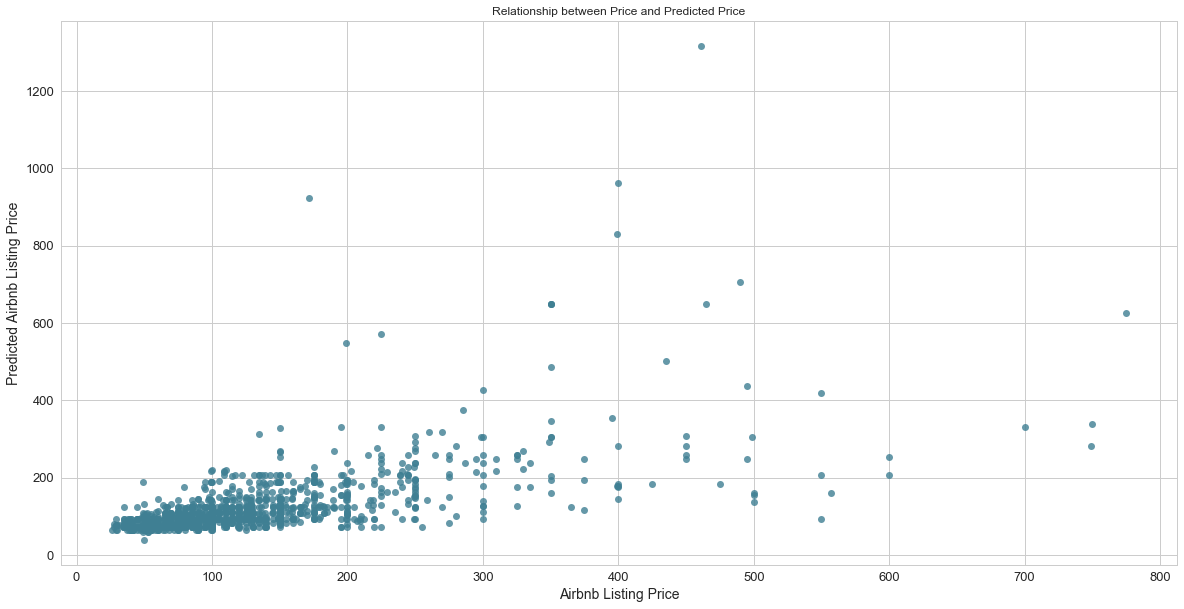

In [27]:
summary(np.exp(y_test), np.exp(y_pred))